In [139]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


import seaborn as sns
import pandas as pd
import numpy as np
import json
import glob
import re
import matplotlib.pyplot as plt

In [140]:
folder = "logs/07_D"

lines = []
for file_name in glob.glob("*.log", root_dir=folder):
    with open(folder + "/" + file_name) as f:
        while line := f.readline():
            if "PFSTT" in line and "dashboard is deleting returned header" not in line:
                json_string = re.search(r'PFSTT(.*?)TTSFP', line).group(1)
                try:
                    lines.append(json.loads(json_string))
                except:
                    print("Error in file: " + file_name)
                    print("Line: " + line)
                    print("JSON: " + json_string)
                    print("-----")
                    continue

df = pd.DataFrame(lines)
# Set Data Types
df["start"] = df["start"].astype(float)
df["end"] = df["end"].astype(float)
df["request_timestamp"] = df["request_timestamp"].astype(float)
df["request_deadline"] = df["request_deadline"].astype(float)

# Calculate Durations
min_timestamp = df["request_timestamp"].min()
last_experiment_timestamp = df["end"].max()
df["request_timestamp"] = df["request_timestamp"] - min_timestamp
df["request_deadline"] = df["request_deadline"] - min_timestamp
df["start"] = df["start"] - min_timestamp
df["end"] = df["end"] - min_timestamp

# Add new columns
df["run_duration"] = df["end"] - df["start"]
df["time_to_deadline"] = df["request_deadline"] - df["start"]
df["init_duration"] = df["start"] - df["request_timestamp"]
df = df.sort_values(by=["function", "start"])
df["start_diff"] = df.groupby("function")["start"].diff()
df['line_segment'] = (df['start_diff'] > 5000).cumsum() # create a new line segment if there is a 5 second break
df

,function,start,end,callid,mode,request_timestamp,request_deadline,run_duration,time_to_deadline,init_duration,start_diff,line_segment
0,check,-50.383545,7.999512,41ed4f63275e4c96b17e2b41525e346c,sync,NaN,NaN,58.383057,NaN,NaN,NaN,0
1,check,899.576660,944.527100,af4b04637b5445dfb2ebbd3441acd664,sync,NaN,NaN,44.950439,NaN,NaN,949.960205,0
2,check,1957.165039,2012.297363,10f26b9cfcb94c7fab7cec013338a843,sync,NaN,NaN,55.132324,NaN,NaN,1057.588379,0
3,check,2948.742432,3019.258301,e2b5266509b84085a4f6c85b8b6803de,sync,NaN,NaN,70.515869,NaN,NaN,991.577393,0
4,check,3927.889648,3979.339600,fbf6df6a9dec48c995336eea7e9ba40f,sync,NaN,NaN,51.449951,NaN,NaN,979.147217,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1795,virus,955183.982910,955218.473389,571373ec119d4e9dac34891f69bdbe99,bored,894891.0,1074891.0,34.490479,119707.017090,60292.982910,107.626465,100
1796,virus,955277.941650,955321.891113,453043c9e1c144d48864a0d3582b61bb,bored,895903.0,1075903.0,43.949463,120625.058350,59374.941650,93.958740,100
1797,virus,955403.325195,955445.376709,c1d441a405d443f9bb847c09658d1158,bored,896865.0,1076865.0,42.051514,121461.674805,58538.325195,125.383545,100
1798,virus,955503.914307,955545.573486,ae14284cd3d34cb5b6b6006516fd2beb,bored,897984.0,1077984.0,41.659180,122480.085693,57519.914307,100.589111,100


In [141]:
# If you want all CPU usage values in the df set this to False
ONLY_RELEVANT_CPU = True

smaller_dfs = []
for file_name in glob.glob("*.csv", root_dir="usage/"):
    # if ONLY_RELEVANT_CPU:
    #     start_ts = int(file_name.split("_")[3].split(".")[0])
    #     if start_ts > last_experiment_timestamp or start_ts < min_timestamp - 1000*60*60*24:
    #         continue
    with open("usage/" + file_name) as f:
        smaller_dfs.append(pd.read_csv(f))
usage_df = pd.concat(smaller_dfs)
usage_df["experiment_time"] = usage_df["unix_time"] - min_timestamp

if ONLY_RELEVANT_CPU:
    # Delete all values 10 seconds after the last call ended and 10 seconds before the first call started
    print("removed before:" + str(len(usage_df[usage_df["unix_time"] <= (last_experiment_timestamp + 10000)])))
    usage_df = usage_df[usage_df["unix_time"] <= (last_experiment_timestamp + 10000)]
    print("removed after:" + str(len(usage_df[usage_df["unix_time"] >= (min_timestamp - 10000)])))
    usage_df = usage_df[usage_df["unix_time"] >= (min_timestamp - 10000)]

usage_df

removed before:3265
removed after:513


,unix_time,cpu_percent,ram_percent,experiment_time
0,1695116578352,6.60,10.94,-7963.0
1,1695116580364,15.26,11.02,-5951.0
2,1695116582375,84.97,10.98,-3940.0
3,1695116584393,96.23,11.03,-1922.0
4,1695116586429,90.12,11.07,114.0
...,...,...,...,...
508,1695117608844,22.91,14.64,1022529.0
509,1695117610884,21.84,14.63,1024569.0
510,1695117612908,21.97,14.63,1026593.0
511,1695117614920,26.11,14.64,1028605.0


In [142]:
min_timestamp

1695116586315.0

<Axes: xlabel='request_timestamp', ylabel='run_duration'>

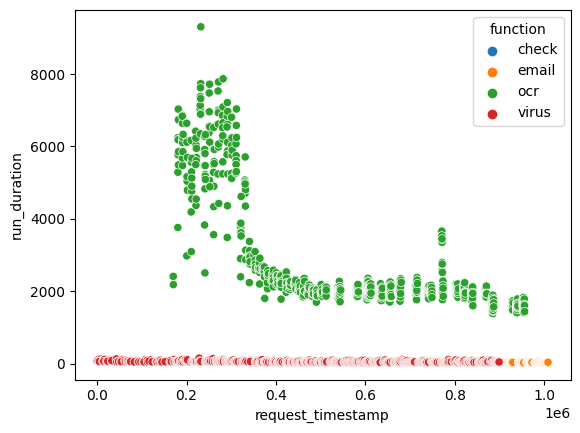

In [143]:
sns.scatterplot(data=df, x="request_timestamp", y="run_duration", hue="function")

<Axes: xlabel='request_timestamp'>

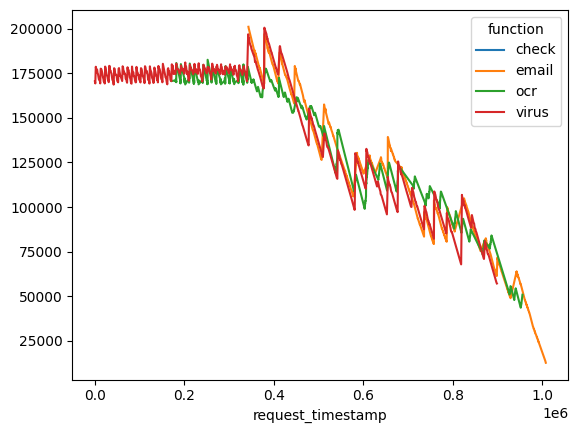

In [144]:
sns.lineplot(data=df, x="request_timestamp", y=df["start"]-df["request_timestamp"], hue="function")


<Axes: xlabel='experiment_time', ylabel='cpu_percent'>

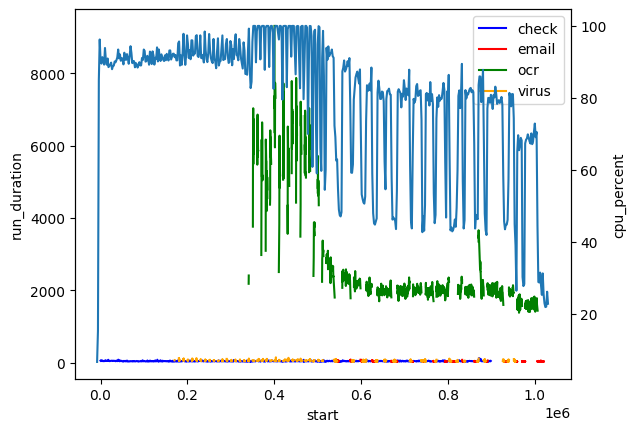

In [145]:
colors = {
    "check": "blue",
    "virus": "orange",
    "ocr": "green",
    "email": "red"
}
for (function, segment), group in df.groupby(["function", "line_segment"]):
    sns.lineplot(data=group, x="start", y="run_duration", color=colors[function], errorbar="ci", label=function, legend="brief")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
ax2 = plt.twinx()
sns.lineplot(ax=ax2, data=usage_df, x="experiment_time", y="cpu_percent")

<Axes: xlabel='experiment_time', ylabel='cpu_percent'>

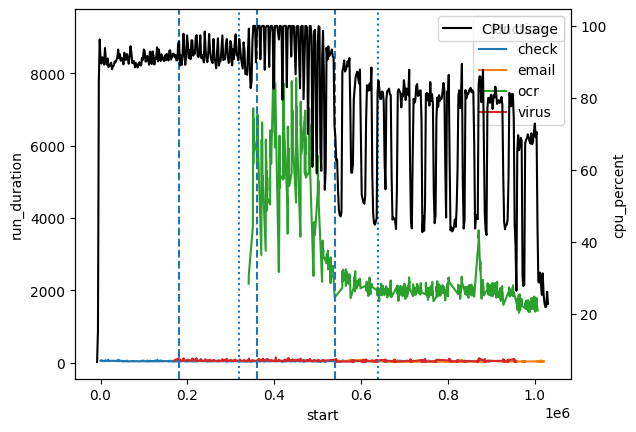

In [162]:
sns.lineplot(data=df, x="start", y="run_duration", hue="function")
plt.axvline(180_000, linestyle="dashed")
plt.axvline(360_000, linestyle="dashed")
plt.axvline(540_000, linestyle="dashed")
plt.axvline(320_000, linestyle="dotted")
plt.axvline(640_000, linestyle="dotted")
ax = plt.gca()
ax2 = plt.twinx()
sns.lineplot(ax=ax2, data=usage_df, x="experiment_time", y="cpu_percent", label="CPU Usage", color="black")


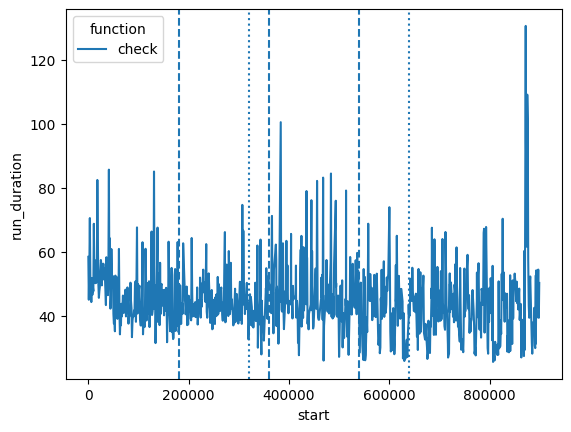

In [163]:
sns.lineplot(data=df[df["function"] == "check"], x="start", y="run_duration", hue="function")
# also plot a rolling average over 10000ms of run_duration. This is to smooth out the graph
plt.axvline(180_000, linestyle="dashed")
plt.axvline(360_000, linestyle="dashed")
plt.axvline(540_000, linestyle="dashed")
plt.axvline(320_000, linestyle="dotted")
plt.axvline(640_000, linestyle="dotted")


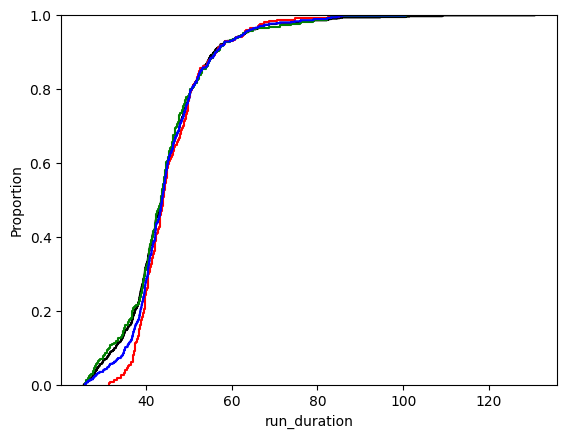

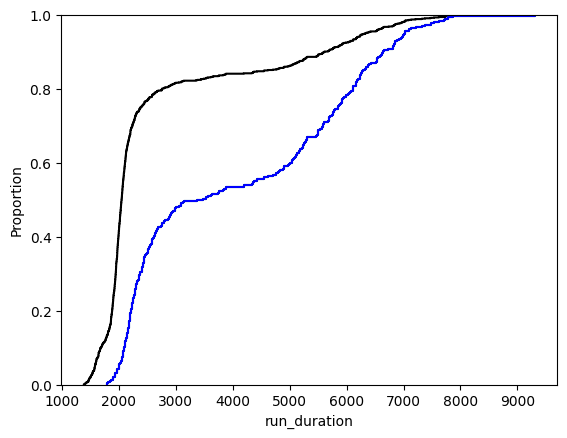

In [172]:
def plot_function_time_cpu(df, function_name, boundary=[320_000, 640_000]):
    sns.ecdfplot(data=df[df["function"] == function_name], x="run_duration", label="Overall", color="black")
    only_check = df[df["function"] == function_name]
    high_load = only_check[only_check["start"] < boundary[0]]
    lin_load = only_check[(only_check["start"] > boundary[0]) & (only_check["start"] < boundary[1])]
    low_load = only_check[only_check["start"] < boundary[1]]
    sns.ecdfplot(data=high_load, x="run_duration", color="red", label="High Load")
    sns.ecdfplot(data=lin_load, x="run_duration", color="green", label="Linear Load")
    sns.ecdfplot(data=low_load, x="run_duration", color="blue", label="Low Load")

plot_function_time_cpu(df, "check")
plt.show()
plot_function_time_cpu(df, "ocr")

<Axes: >

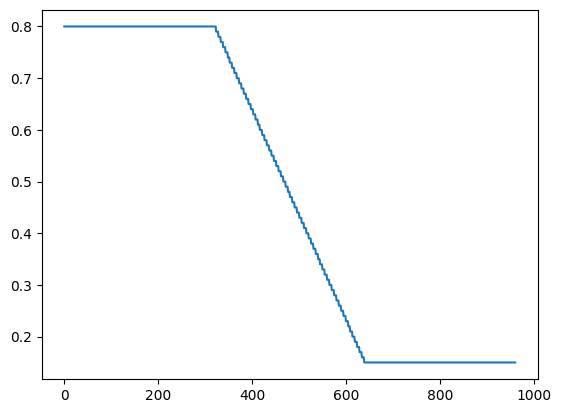

In [149]:
def get_cpu_share(start, end, current):
    # get the length of the experiment
    length = end - start
    # get the current time in the experiment
    current = current - start

    # if the current time is in the first third of the experiment
    if current < length/3:
        return "0.80"
    # if the current time is in the last third of the experiment
    elif current > 2*length/3:
        return "0.15"
    # if the current time is in the middle third of the experiment
    else:
        # calculate the cpu share based on the current time
        return str(round(((-1.95/length)*current + 1.45), 2))
        # the value if you want to go from 50 to 15:
        # return str(round(((-105/length)*current + 85)/100, 2))

start = 0
end = 16 * 60
sns.lineplot([float(get_cpu_share(start, end, i)) for i in range(start, end)])